## Scraping top repositories from popular topics (GitHub): A WEB-SCRAPING PROJECT

- Please go through the Project-Rough Code first to understand step-by-step process of this project

## Problem Statement: 
- Gather the Title, Topic Decription & Topic url for top featured topics in the topics column of GitHub page
- Save this in the pandas Data Frame form.
- For each topic, Scrape the Username, Repository Name, repository url and No. of Stars for:
- Top 30 repositories in each topic
- At the end, save the data in CSV form at a specific folder path.

## Tools used:
- Python, Requests module, BeautifulSoup, Pandas, os module, Jupyter Notebook

### PROJECT OUTLINE:
- I am going to scrape: https://github.com/topics website
- Getting different topics from this page. For each topic gather: Topic Title, Topic page URL,
  Topic description and saving it in a csv
- For each topic, the titles of top 25 to 30 repositories in the topic from each 
  topic page
- For each Repository,the Username who posted the repository, the Repository Name, the repository URL and the no. of stars would be gathered.
- All the above data would be saved in CSV file.

## Part-1: Getting the top featured topics from GitHub-Topics page.

In [43]:
!pip install requests --upgrade --quiet         # Installing requests, BeautifulSoup by Jupyter Notebook itself
!pip install beautifulsoup4 --upgrade --quiet 

ERROR: Invalid requirement: '#'


- Writing Functions for :
- Getting Topic names
- Getting Topic Descriptions
- Getting topic URLs

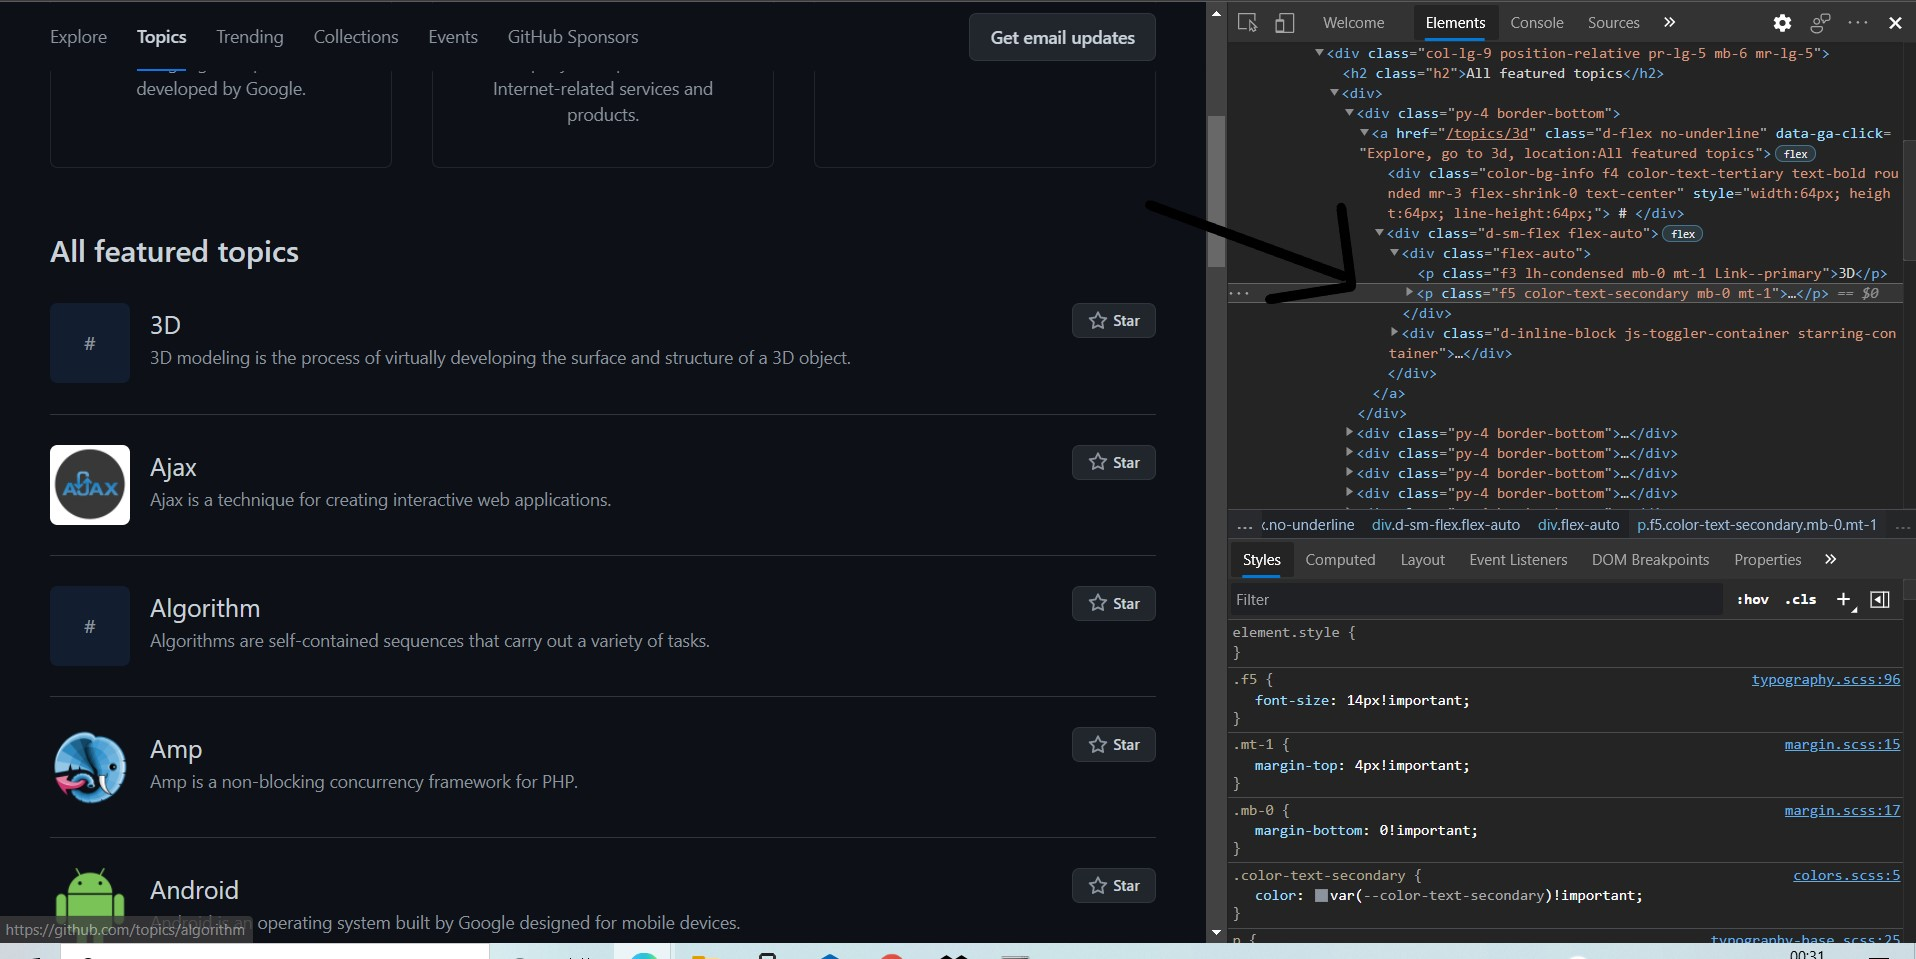      
- Go through the image to see what to look in the inspect window of browser.
- As shown, search for all the p tags to get the information of each topic

In [1]:
import os
import requests
from bs4 import BeautifulSoup
import pandas as pd

In [32]:
def get_topic_titles(soup):
    selection_class = 'f3 lh-condensed mb-0 mt-1 Link--primary'
    topic_title_tags = soup.find_all('p', {'class' : selection_class})
    topic_titles = []
    for tags in topic_title_tags:
        topic_titles.append(tags.text)
    return topic_titles

In [33]:
def get_topic_descs(soup):
    desc_selector = "f5 color-text-secondary mb-0 mt-1"
    topic_desc_tags = soup.find_all('p', {'class' : desc_selector})
    topic_descs = []
    for tags in topic_desc_tags:
        topic_descs.append(tags.text.strip())
    return topic_descs

In [34]:
base_url = 'https://github.com'
def get_topic_urls(soup):
    topic_link_tags = soup.find_all('a', class_ = 'd-flex no-underline')
    topic_urls = []
    base_url = 'https://github.com'
    for tags in topic_link_tags:
        topic_urls.append(base_url + tags['href'])
    return topic_urls  

In [35]:
def  scrape_topics():
    # download the webpage clone and save it in response
    response = requests.get(topics_url)
    if response.status_code not in range(200,300):
        raise Exception("Failed to load page {}".format(topic_url))
    page_contents = response.text
    # Parse the webpage into html form using BeautifulSoup
    soup = BeautifulSoup(page_contents, 'html.parser')
    topics_dict = {
        'title': get_topic_titles(soup),
        'descriptions' : get_topic_descs(soup),
        'topic_url' : get_topic_urls(soup),
    }
    return pd.DataFrame(topics_dict)    # returns in pandas Data Frame form

## Step-2: Getting top 30 repositories from each topic and know:
- The Repository name
- The username of their admins
- Repository links for each project

In [36]:
def get_subtopic_page(topic_urls):
    #Download the page
    response = requests.get(topic_urls)
    # Check successful response
    if response.status_code not in range(200,300):
        raise Exception("Failed to load page {}".format(topic_urls))
    # Parse web-data using Beautiful_Soup
    subtopic_soup = BeautifulSoup(response.text, 'html.parser')
    return subtopic_soup

- Get info from each repositories and changing the format of star counts.
  ex - 67.5k stars would be 67500

In [37]:
def parse_star_count(ele):
    ele = ele.strip()
    if ele[-1] == 'k':
        return int(float(ele[:-1])*1000)
    return int(ele)

def get_repo_info(h1_tag, star_tag):
    # Returns all the required info about the repository
    a_tags = h1_tag.find_all('a')
    username = a_tags[0].text.strip()
    repo_name = a_tags[1].text.strip()
    repo_url = base_url + a_tags[1]['href']
    stars = parse_star_count(star_tag.text.strip())
    return username, repo_name, stars, repo_url

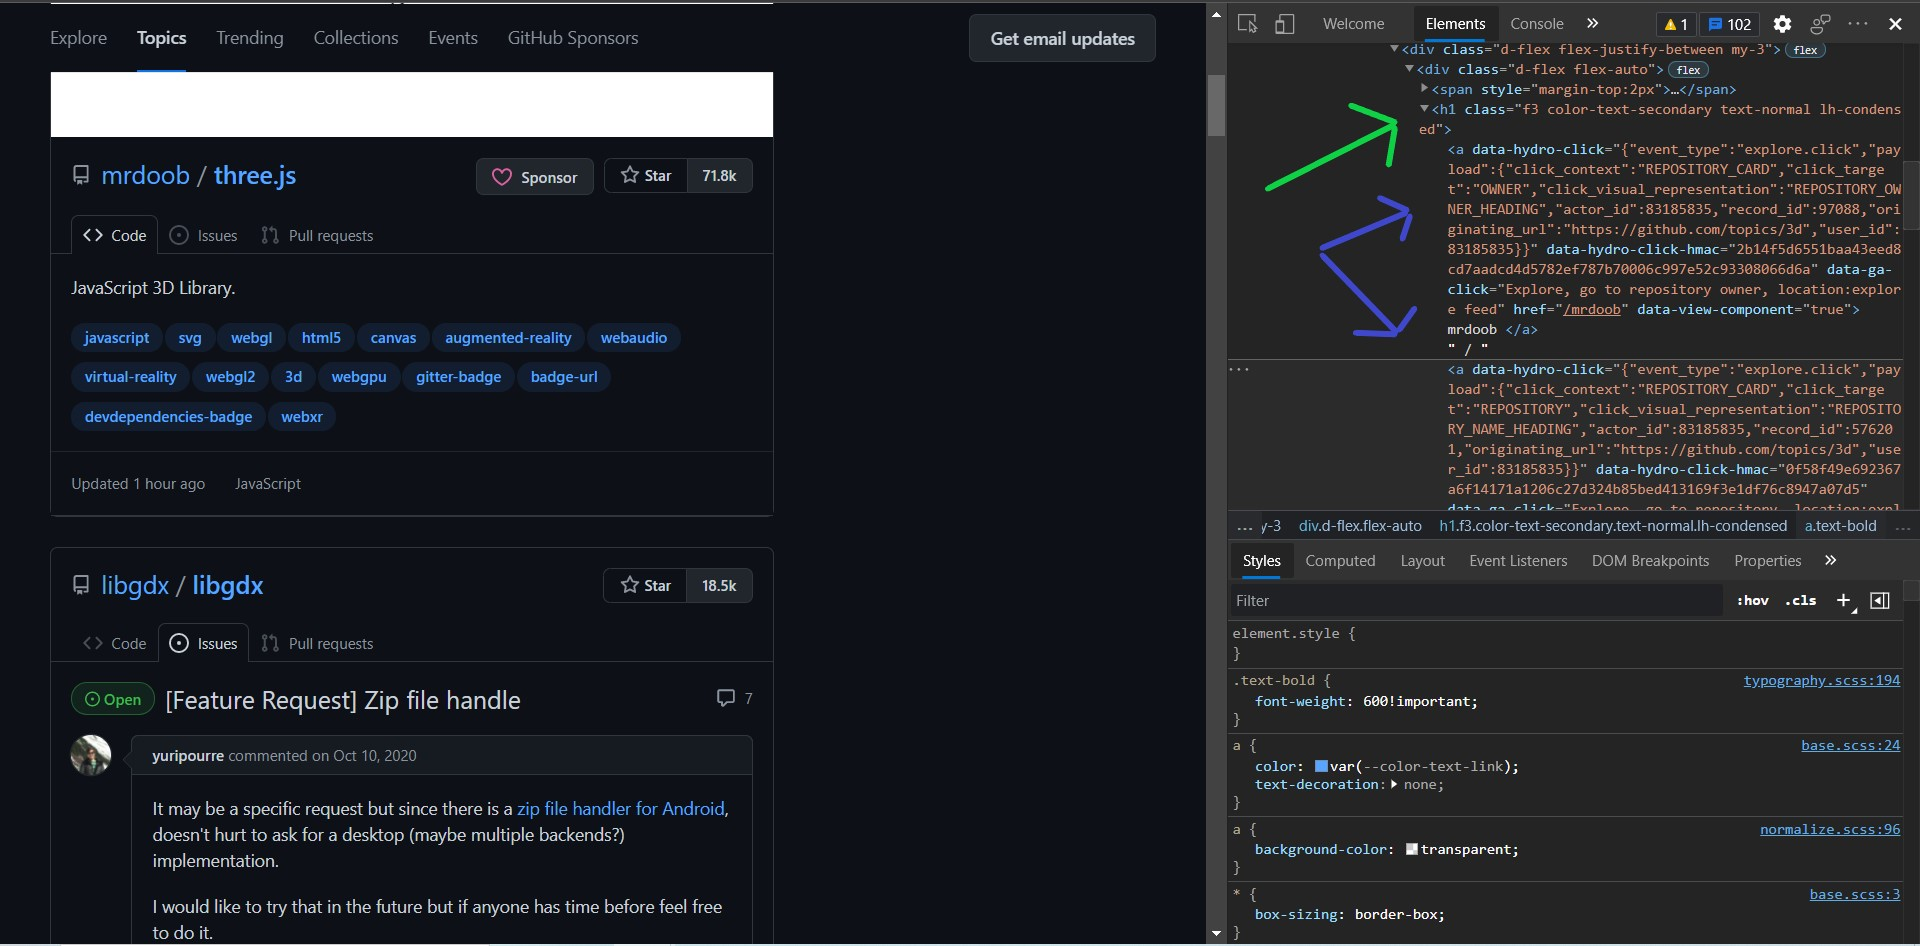

- Green for lookin h1_repo tags which contains:
- 2 'a' tags containing the username, repo_name & repo_url( Shown with blue arrows)

In [10]:
def get_subtopic_repos(subtopic_soup):
    # gets the h1-tags containing username, repo_name & repo_url
    h1_finder_class = 'f3 color-text-secondary text-normal lh-condensed'
    h1_repo_tags = subtopic_soup.find_all('h1', {'class': h1_finder_class})
    # gets the star_tags containing the no of stars in each repos
    star_finder_class = 'social-count float-none'
    star_tags = subtopic_soup.find_all('a', class_ = star_finder_class)
    
     # Get required data for each repository under the main topic and stores
     # it as a dictionary
    topic_repos_dict = {
        'username' : [],
        'repo_name' : [],
        'stars' : [],
        'repo_url' : [],
    }
    
    for i in range(len(h1_repo_tags)):
        repo_info = get_repo_info(h1_repo_tags[i], star_tags[i])
        topic_repos_dict['username'].append(repo_info[0])
        topic_repos_dict['repo_name'].append(repo_info[1])
        topic_repos_dict['stars'].append(repo_info[2])
        topic_repos_dict['repo_url'].append(repo_info[3])
    
    return pd.DataFrame(topic_repos_dict)

- Creating a helper function to save data from each repository into csv format

In [40]:
def scrape_subtopic(topic_url, path):
    if os.path.exists(path):
        print(f"The file {path} already exists. Skipping...")
        return
    subtopic_df = get_subtopic_repos(get_subtopic_page(topic_url))
    subtopic_df.to_csv(path, index=None)

## The Master Code to run the Scraping Formula from each function:

In [39]:
topics_url = 'https://github.com/topics'
topics_df = scrape_topics()
def scrape_topics_repos():
    # Creating a separate folder = 'scraped_data(github)'
    os.makedirs('scraped_data(github)', exist_ok = True)
    print(f"Scraping list of topics from {topics_url}")
    topics_df = scrape_topics()
    for index,row in topics_df.iterrows():
        print(f"Scraping top repositories for {row['title']}")
        scrape_subtopic(row['topic_url'], f"scraped_data(github)/{row['title']}.csv")

In [ ]:
scrape_topics_repos()